# Benchmark: PXD038699

Spatial single-cell mass spectrometry dataset available at [PRIDE](https://www.ebi.ac.uk/pride/archive/projects/PXD038699).

Differential expression:
 - PV markers: Asl, Cyp2e1
 - Zonation anchor proteins, enriched gene sets along zonation axis ("Positive controls for low-input proteomics")
   - protein sets for electron transport chain and oxidative phosphorylation (OXPHOS) were among processes upregulated in proximity to the PV
   - biotransformation and oxidations by cytochrome P450 were increased proximal to the CV

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../../data/raw/PXD038699/"

ANNOTATIONS_PATH = os.path.join(DATA_DIR, "meta_scDVP.tsv")
DATA_PATH = os.path.join(DATA_DIR, "proteintable_scDVP.tsv")

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")
annotations = pd.read_csv(ANNOTATIONS_PATH, sep="\t")

annotations["id"] = annotations["FileName"] + "_" + annotations["label"]
annotations.set_index("id", inplace=True)

var_cols = [c for c in data.columns if "TIMS" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = data.index.copy()

obs = pd.DataFrame(index=obs_names)
obs = obs.join(annotations, how="left")

adata = sc.AnnData(X=data, obs=obs, var=vars)

categories =  ["cell_ID", "bio_ID", "label", "Image_index"]
adata.obs[categories] = adata.obs[categories].astype("category")

adata = adata[~np.all(np.isnan(adata.X), axis=1), :].copy()
adata = adata[:, ~np.all(np.isnan(adata.X), axis=0)].copy()

adata.layers["raw"] = adata.X.copy()

In [4]:
#utils.filter_by_detection_proportion(adata, min_coverage=0.1)

In [5]:
adata

AnnData object with n_obs × n_vars = 523 × 3738
    obs: 'FileName', 'cell_ID', 'bio_ID', 'label', 'Image_index'
    var: 'protein'
    layers: 'raw'

## Data Exploration

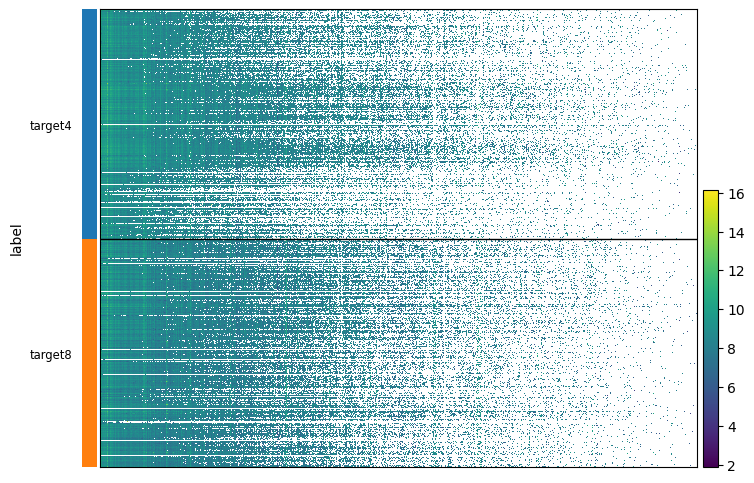

In [6]:
adata = utils.sort_anndata_by_missingness(adata)

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="label", show_gene_labels=False)

In [7]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="raw")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 0.00%


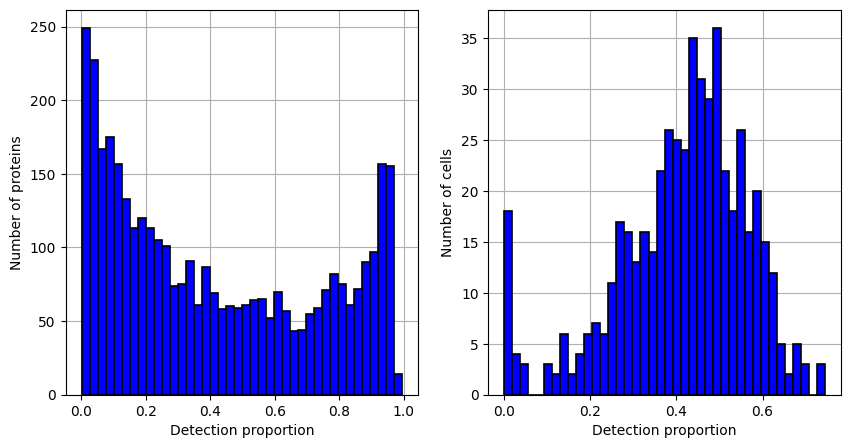

In [8]:
mask = np.isnan(adata.X)

p_protein = (~mask).mean(axis=0)
p_cell = (~mask).mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(p_protein, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of proteins")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.hist(p_cell, bins=40, edgecolor="black", linewidth=1.2, color="blue")
ax.set_xlabel("Detection proportion")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

Let's see if we can decide which annotation is the batch effect.

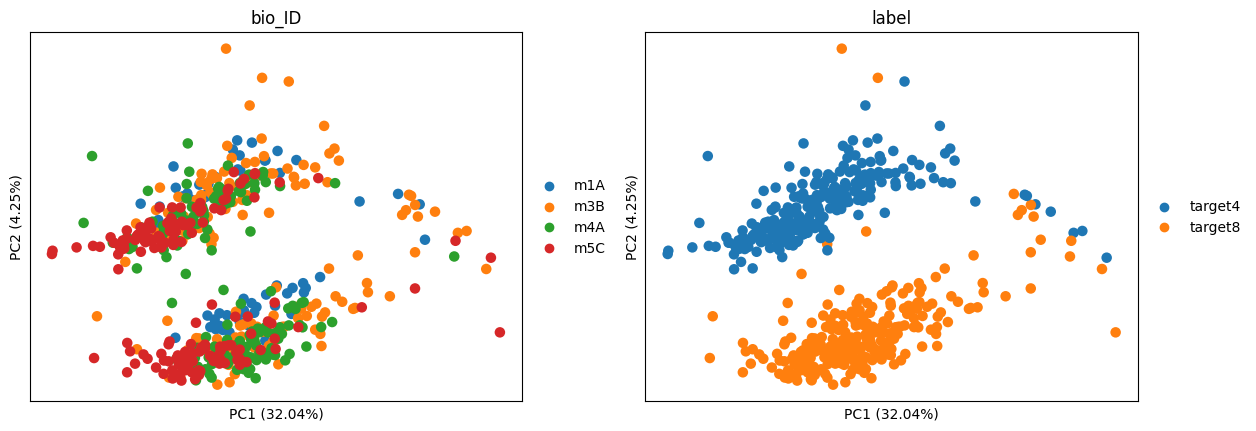

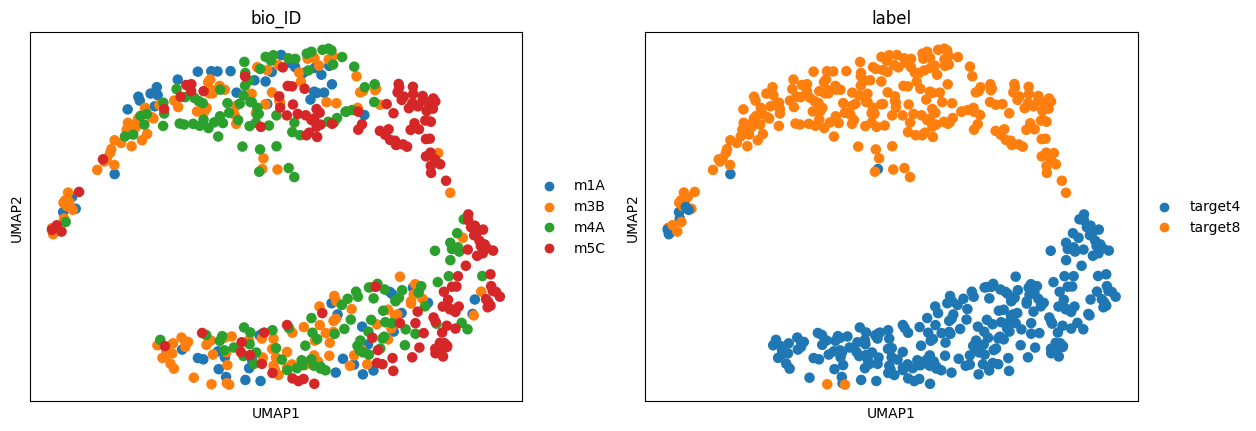

In [9]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["bio_ID", "label"],
    components=["1,2"],
)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["bio_ID", "label"],
)

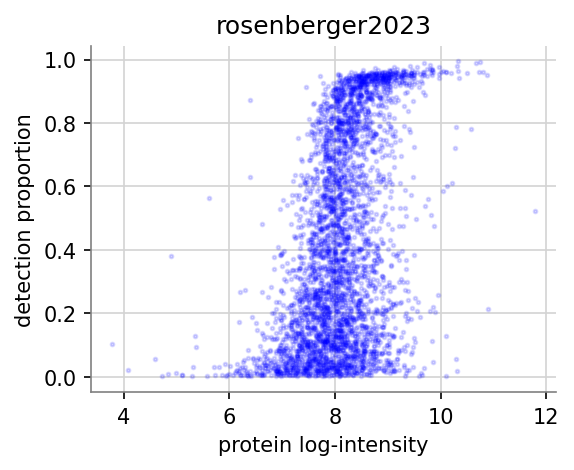

In [16]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="rosenberger2023")